# Tutorial 1 - Using a Quantum Device to solve MIS


Maximum Independent Set (MIS) is a standard and widespread graph problem in scheduling, network theory, error correction, and even in the quantum sector as part of more general optimization algorithms (e.g., QUBO formulations) or as a benchmark on quantum annealers or neutral atom devices.

There is currently no known polynomial-time algorithm for general graphs running on classical (non-quantum) devices, which means that, in practice, finding an exact solution for large graphs is generally not possible due to time and hardware limitations. For this reason, most applications of MIS must satisfy themselves with finding approximate solutions. As it turns out, in some cases, even finding approximate solutions is considered hard. For these reasons, there is high interest in solving MIS on Quantum Devices.

This library does just that: it compiles an MIS into a form suited for execution on existing analog quantum hardware, such as the commercial QPUs produced by Pasqal. No knowledge of quantum programming is necessary and no quantum computer is needed to test-drive the library. In this tutorial, we will walk you through executing an instance of MIS, using both classical and quantum methods.

By the end of this notebook, you will know how to:

- Setup import for standard MIS benchmarking DIMACS datasets.
- Setup compilation and execution of these graphs for execution on both Classical and Quantum Device (either an emulator or a physical QPU).
- Launch the execution and extract relevant results.

## The MIS problem

The MIS problem can be formulated as follows: given a graph $G=(V,E)$, an independent set is a subset of vertices $S\subseteq V$ such that no two vertices in $S$ are connected by an edge. The MIS problem then seeks to find the largest independent set in $G$.


## Dataset preparation

As in any MIS process, we first need to load and prepare data in a suitable graph format. For this tutorial, we will use the standard benchmark [DIMACS datasets](https://oeis.org/A265032/a265032.html) of various sizes and convert them to supported [Networkx](https://networkx.org/documentation/stable/index.html#) graph types.

In [1]:
# Ignore warnings for this tutorial.
import logging
import os
import sys

logger = logging.getLogger()
logger.disabled = True

sys.stderr = open(os.devnull, 'w')

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


In [2]:
import networkx as nx

# Create a new networkx graph instance to be populated with DIMACS data.
graph = nx.Graph()


with open("./datasets/dimacs/a265032_1tc.16.txt", "r") as f:
    for line in f:
        if line.startswith("c"):  # Comment line in DIMACS file.
            continue
        elif line.startswith("p"):  # Problem definition, i.e. # nodes and edges.
            _, _, num_nodes, num_edges = line.strip().split()
            # Preset graph node labels as there might be isolated ones.
            graph.add_nodes_from(range(1, int(num_nodes) + 1))

        elif line.startswith("e"):
            _, node1, node2 = line.strip().split()
            graph.add_edge(int(node1), int(node2))

# Let's check what the graph looks like.
print(graph)


Graph with 16 nodes and 22 edges


## Solving MIS using a non-quantum solver

Let's first solve this instance of MIS using standard heuristics.

preprocessing - current kernel size is 16
preprocessing - complete


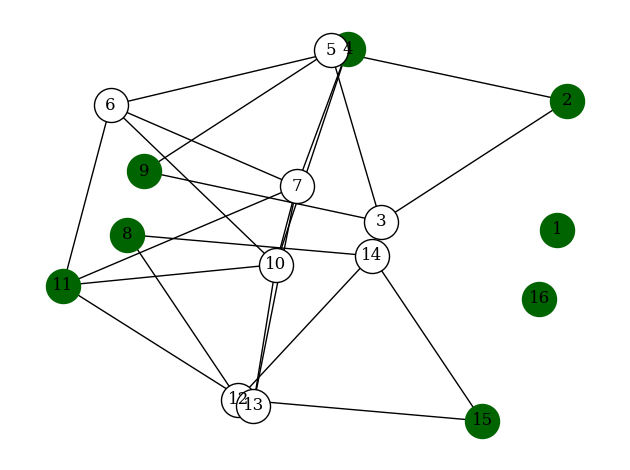

Solution nodes:  [1, 2, 4, 8, 9, 11, 15, 16]
Solution frequency: 1.0
Solution size: 8


In [3]:
from mis import MISSolver, MISInstance, SolverConfig
# Define classical solver configuration

# Use a default configuration for the library.
# By default, the library uses a classical (non-quantum)
# heuristic solver.
config = SolverConfig()

# Create the MIS instance.
instance = MISInstance(graph)

# Run the solver and retrieve results.
solver = MISSolver(instance, config)
solutions = solver.solve()

# Display results
solutions[0].draw()
print("Solution nodes: ", solutions[0].nodes)
print("Solution frequency:", solutions[0].frequency)
print("Solution size:", solutions[0].size)

In this instance, we have used the default (non-quantum) solver. This solver is based on the [approximate MIS solver in Networkx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.maximum_independent_set.html). From its inherent heuristic and non-deterministic nature, this solver does not guarantee optimality in solution finding.

The solver returns a list of node labels of size 12 which is the unique solution so far (frequency of 1.0).

## Solving using the quantum SDK QuTiP

In the previous section, we have used a non-quantum solver to resolve our instance of MIS. 
In this section, we'll use actually use a quantum algorithm. There are three steps to quantum algorithms:

1. Converting the problem into a Register (the position of atoms in the quantum device) and a Drive (a program in the Rydberg analog model, the one behind neutral atom quantum computers, is defined as a time-dependent drive Hamiltonian)
2. Actually running the Register and program on the quantum device
3. Extracting the results of quantum measurement on the quantum device into a solution to the original problem.

In this library, all three steps are entrusted to the library [QoolQit](https://pasqal-io.github.io/qoolqit/latest/). This library provides several backends, depending on your use. Since you may not have access to a quantum computer for step 2, we will use a `LocalEmulator` based on the quantum SDK `QuTIP`. This is a simple backend that has the advantage of working on most computers, regardless of operating system or GPU.

In [10]:
from mis import LocalEmulator
from qoolqit.devices import MockDevice, Device
from emu_sv import SVBackend
# from pulser.devices import VirtualDevice as PVirtualDevice

# class VirtualDevice(Device):
#     """A device with digital and analog capabilites."""

#     def __init__(self) -> None:
#         super().__init__(pulser_device=PVirtualDevice)

# deactivate preprocessor to run on quantum, as preprocessor will skip running on device
solver_config = SolverConfig(
    # Use the QuTIP backend.
    backend = LocalEmulator(backend_type=SVBackend),
    device=MockDevice(),
    # Perform up to 10 quantum measures.
    max_iterations=10,
    preprocessor=None,
    
)

# Run the solver
solver = MISSolver(instance, solver_config)
solutions = solver.solve()

# Display results
print("MIS solution:", solutions[0].nodes)
print("Solution frequency:", solutions[0].frequency)
print("Solution size:", solutions[0].size)
solutions[0].draw()

RecursionError: exponentiation algorithm did not converge to precision in allotted number of steps.

Note that any quantum algorithm is, by definition, non-deterministic, so there is no guarantee
that this will be the same solution as the non-quantum solver.

## Solving using Remote QPU backend

This section illustrates the use of a QPU backend hosted on Pasqal's Cloud Platform. Provided that you are granted with credentials to access the platform, they should be passed to instantiate a `QPU` backend.

In [ ]:
from mis import QPU, PasqalCloud

# Replace with your username, project id and password on the Pasqal Cloud.
USERNAME="username"
PROJECT_ID="123"
PASSWORD=None

if PASSWORD is not None:
    # deactivate preprocessor to run on quantum, as preprocessor will skip running on device
    connection = PasqalCloud(
        username=USERNAME,
        password=PASSWORD,
        project_id=PROJECT_ID,
    )
    config = SolverConfig(
        backend = QPU(connection=connection),
        max_iterations=10,
        preprocessor=None,
    )

    # Run the solver
    solver = MISSolver(instance, config)
    solutions = solver.solve()

    # Display results
    print("MIS solution:", solutions[0].nodes)
    print("Solution frequency:", solutions[0].frequency)
    solutions[0].draw()